In [383]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [384]:
# Lendo os dados 

dados_treino = pd.read_csv("dados/train.csv")
dados_teste = pd.read_csv("dados/test.csv")

dados_treino.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Análise Exploratória

In [385]:
print(dados_treino.describe(), dados_treino.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    

A variável PassengerId está marcada como inteiro, porém como trata-se de um indicador, sabemos que está errado, por fins de não aplicação da variável por agora, vamos manter do jeito que está.

A variáveis binárias e de fator também são marcadas como inteiras: Survived, Pclass.

Temos também duas variáveis de contagem: SibSp e Parch, podemos tentar transformar em uma nova preditora combinando essas duas variáveis.

As variáveis numéricas são Age e Fare - Vamos realizar uma decomposição usando PCR para tentar encontrar uma nova variável como combinação delas.

Importante notar que temos 891 observações, em Age temos quase 200 dados faltantes e a variável Cabin possui quase 700, por esses motivos, vamos evitar usar a variável Cabin, mesmo sabendo que essa variável contém informações importantes acerca da administração do alocamento do navio, sendo uma preditora muito forte, dado que pessoas alocadas em locais de fácil saída de emergência eram mais privilegiadas.

Para Age vamos completar os dados faltantes pela mediana ou podemos também ajustar uma regressão, o que for mais cômodo para o projeto.

Nossas variáveis preditoras por enquanto:

- Pclass (Fator)
- Sex (Binária)
- Age (Inteira)
- SibSp (Inteira - contagem)
- Parch (Inteira - contagem)
- Fare (Contínua)
- Embarked (Fator)

E a target:

- Survived (Binária)

Nossas variáveis preditoras por enquanto:

- Pclass
- Sex
- Age
- SibSp
- Parch
- Fare
- Embarked

E a target:

- Survived

## Analisando o Sexo dos passageiros 

In [386]:
resumo_sexo = dados_treino.groupby(["Sex", "Survived"]).size().unstack()

resumo_sexo

Survived,0,1
Sex,,
female,81,233
male,468,109


Tinham muito mais homens no navio

(array([0, 1]), [Text(0, 0, 'female'), Text(1, 0, 'male')])

<Figure size 900x600 with 0 Axes>

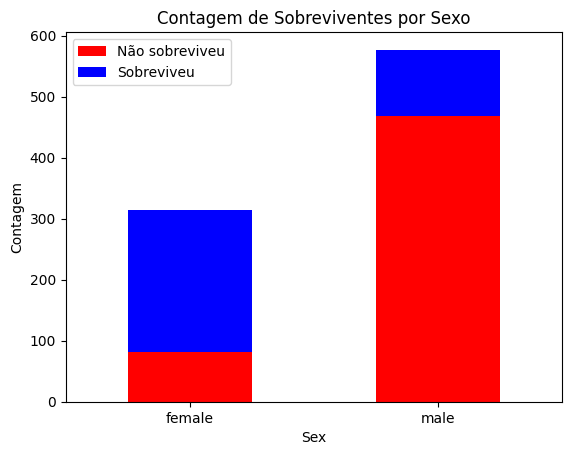

In [387]:
plt.figure(figsize= (9,6))

resumo_sexo.plot(kind="bar", stacked=True, color=["red", "blue"])

plt.title("Contagem de Sobreviventes por Sexo")
plt.ylabel("Contagem")
plt.legend(["Não sobreviveu", "Sobreviveu"], loc="upper left")
plt.xticks(rotation=0)

O gráfico conta uma história muito interessante, onde mais homens sobreviveram e morreram, isso é, logicamente, um problema de proporção, vamos criar um gráfico proporcional

(array([0, 1]), [Text(0, 0, 'female'), Text(1, 0, 'male')])

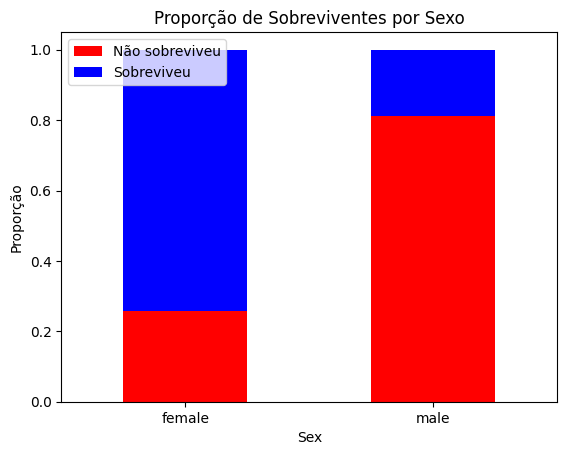

In [388]:
resumo_sexo.divide(resumo_sexo.sum(axis=1), axis=0).plot(kind="bar", stacked=True, color=["red", "blue"])

plt.title("Proporção de Sobreviventes por Sexo")
plt.ylabel("Proporção")
plt.legend(["Não sobreviveu", "Sobreviveu"], loc="upper left")
plt.xticks(rotation=0)

Antes de qualquer comentário vamos criar uma tabela com os números para entender melhor

In [389]:
resumo_sexo.divide(resumo_sexo.sum(axis=1), axis=0)*100

Survived,0,1
Sex,,
female,25.796178,74.203822
male,81.109185,18.890815


Bem, é notório a diferença gigantesca para a sobrevivência dos passageiros, onde mulheres aparecem com mais de 80% de sobrevivência e homens com pouco menos de 20%.

Tornando assim uma grande variável preditora pro nosso modelo, vamos tomar cuidado ao dividir os dados de treino e validação no modelo com uma simples AAS, pois isso poderia omitir importantes informações sobre a sobrevivência do passageiro, visto que a probabilidade de escolhermos mais homens (cuja a taxa de sobrevivência é menor) é maior que escolhermos mulheres. Para o split, seria interessante usar uma amostragem estratificada.

## Analisando a Classe dos passageiros

In [390]:
resumo_classe = dados_treino.groupby(["Pclass", "Survived"]).size().unstack()

resumo_classe

Survived,0,1
Pclass,,
1,80,136
2,97,87
3,372,119


Existiam muito mais pessoas de terceira classe no navio

(array([0, 1, 2]), [Text(0, 0, '1'), Text(1, 0, '2'), Text(2, 0, '3')])

<Figure size 900x600 with 0 Axes>

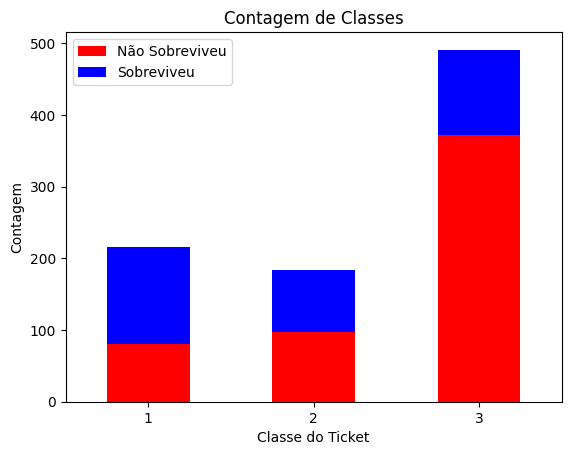

In [391]:
plt.figure(figsize= (9,6))

resumo_classe.plot(kind = "bar", stacked = True, color = ["red", "blue"])

plt.title("Contagem de Classes")
plt.xlabel("Classe do Ticket")
plt.ylabel("Contagem")
plt.legend(["Não Sobreviveu", "Sobreviveu"], loc = "upper left")
plt.xticks(rotation = 0)

De mesma maneira vamos criar o gráfico proporcional

(array([0, 1, 2]), [Text(0, 0, '1'), Text(1, 0, '2'), Text(2, 0, '3')])

<Figure size 900x600 with 0 Axes>

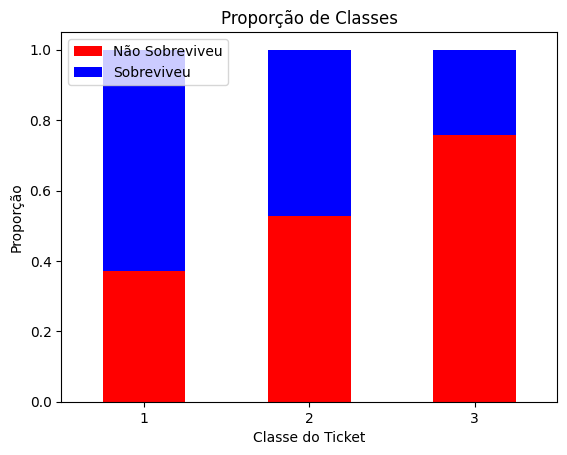

In [392]:
plt.figure(figsize= (9,6))

resumo_classe.divide(resumo_classe.sum(axis = 1), axis = 0).plot(kind = "bar", stacked = True, color = ["red", "blue"])

plt.title("Proporção de Classes")
plt.xlabel("Classe do Ticket")
plt.ylabel("Proporção")
plt.legend(["Não Sobreviveu", "Sobreviveu"], loc = "upper left")
plt.xticks(rotation = 0)

In [393]:
resumo_classe.divide(resumo_classe.sum(axis = 1), axis = 0)*100

Survived,0,1
Pclass,,
1,37.037037,62.962963
2,52.717391,47.282609
3,75.763747,24.236253


O padrão é claro, pessoas de classes altas possuem mais sobreviventes que pessoas de tickets de classes mais baixas. 

Pelo mesmo motivo da variável Sex, Pclass é também uma grande preditora, mas vamos fazer o split com um estrato para ela, visto que temos muito mais passageiros de classe 3

## Analisando onde embarcaram os passageiros    

In [394]:
resumo_embarque = dados_treino.groupby(["Embarked", "Survived"]).size().unstack()

resumo_embarque

Survived,0,1
Embarked,,
C,75,93
Q,47,30
S,427,217


Southampton foi o local onde mais embarcaram pessoas

Vamos criar o gráfico proporcional

(array([0, 1, 2]), [Text(0, 0, 'C'), Text(1, 0, 'Q'), Text(2, 0, 'S')])

<Figure size 900x600 with 0 Axes>

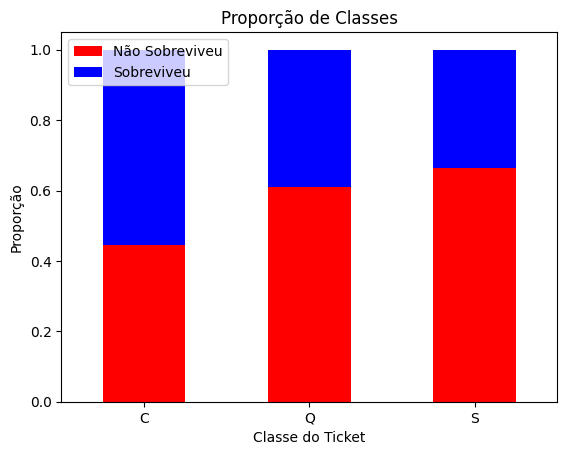

In [395]:
plt.figure(figsize= (9,6))

resumo_embarque.divide(resumo_embarque.sum(axis = 1), axis = 0).plot(kind = "bar", stacked = True, color = ["red", "blue"])

plt.title("Proporção de Classes")
plt.xlabel("Classe do Ticket")
plt.ylabel("Proporção")
plt.legend(["Não Sobreviveu", "Sobreviveu"], loc = "upper left")
plt.xticks(rotation = 0)

E a tabela

In [396]:
resumo_embarque.divide(resumo_embarque.sum(axis = 1), axis = 0)*100

Survived,0,1
Embarked,,
C,44.642857,55.357143
Q,61.038961,38.961039
S,66.304348,33.695652


De Southampton para Queenstown, proporcionalmente não existe tanta diferença, o que muda quando falamos de Cherbourg. 


A seção mostra que, existem proporções de fatores que impactam diretamente na decisão de sobrevivência do passageiro. Por isso, vamos splitar os dados de treino e teste usando o estrato da própria sobrevivência.

# Manipulando Variáveis

Vamos criar duas variáveis usando as contagens de membros de família:

- FamilySize: SibSp + Parch + 1
- IsAlone: Binária, pergunta-se se o passageiro está sozinho na viagem 

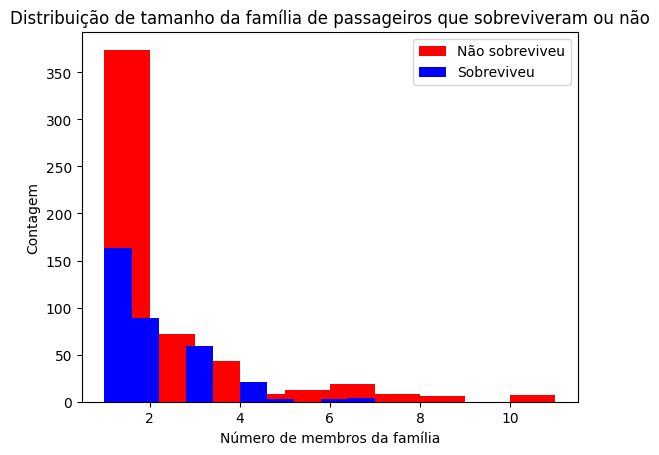

In [397]:
dados_treino["FamilySize"] = dados_treino["SibSp"] + dados_treino["Parch"] + 1

plt.hist(dados_treino[dados_treino["Survived"] == 0]["FamilySize"], color = "red") # Passageiro não sobreviveu
plt.hist(dados_treino[dados_treino["Survived"] == 1]["FamilySize"], color = "blue") # Passageiro sobreviveu

plt.title("Distribuição de tamanho da família de passageiros que sobreviveram ou não")
plt.xlabel("Número de membros da família")
plt.ylabel("Contagem")
plt.legend(["Não sobreviveu", "Sobreviveu"], loc = "upper right")

A taxa de sobrevivência é menos dispersa, concentrando-se fortemente em núcleos familiares pequenos (especialmente entre 2 e 4 membros).

A taxa de não sobrevivência é mais dispersa e se estende por quase todos os tamanhos de família.

Como não é tão linear, o modelo pode não captar as diferenças perfeitamente

(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

<Figure size 900x600 with 0 Axes>

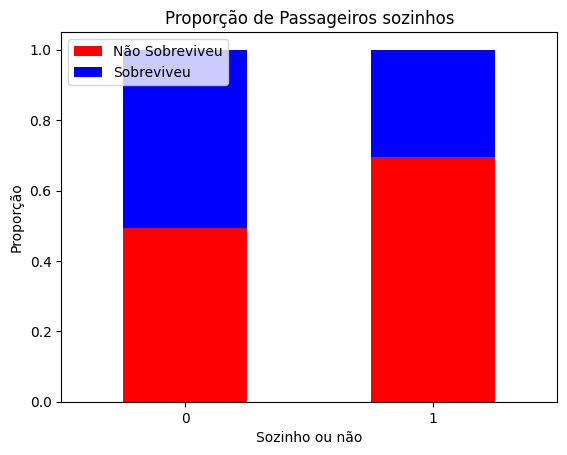

In [398]:
dados_treino['IsAlone'] = np.where(dados_treino['FamilySize'] == 1, 1, 0)

resumo_sozinho = dados_treino.groupby(["IsAlone", "Survived"]).size().unstack()

plt.figure(figsize= (9,6))

resumo_sozinho.divide(resumo_sozinho.sum(axis = 1), axis = 0).plot(kind = "bar", stacked = True, color = ["red", "blue"])

plt.title("Proporção de Passageiros sozinhos")
plt.xlabel("Sozinho ou não")
plt.ylabel("Proporção")
plt.legend(["Não Sobreviveu", "Sobreviveu"], loc = "upper left")
plt.xticks(rotation = 0)


In [399]:
resumo_sozinho.divide(resumo_sozinho.sum(axis = 1), axis = 0)*100

Survived,0,1
IsAlone,,
0,49.435028,50.564972
1,69.646182,30.353818


Por mais que, praticamente metade das pessoas viajando sozinhas sobreviveram, o que significa que a outra metade não sobreviveu, os dados mostram que a taxa de sobrevivência de quem estava acompanhado é menor.

Acredito que, a variável IsAlone tenha mais poder de predição, pois diferencia mais os dados, o que aumenta o leque de interpretabilidade do modelo na hora de aprender.

No fim, iremos testar as duas e ver qual tem mais poder preditivo.

## PCR

Para o PCR, precisamos splitar os dados em treino e teste

Como definimos, vamos amostrar por estratificação por alocação proporcional usando a variável target Survived

Vamos splitar com 70/30 

In [400]:
n_treino = .7*len(dados_treino)
n_teste = .3*len(dados_treino)

W1 = sum(dados_treino["Survived"] == 1) / len(dados_treino) # Peso de proporção de quantos sobreviveram
W2 = sum(dados_treino["Survived"] == 0) / len(dados_treino) # Peso de proporção de quantos não sobreviveram

n_treino_1 = round(n_treino*W1)
n_treino_2 = round(n_treino*W2)


treino_1 = dados_treino[dados_treino["Survived"] == 1].sample(n = n_treino_1, random_state = 27) # Amostra aleatória em cada estrato
treino_2 = dados_treino[dados_treino["Survived"] == 0].sample(n = n_treino_2, random_state = 27)

treino = pd.concat([treino_1, treino_2]) # Junta as amostras
teste = dados_treino.drop(treino.index) # O que sobrou do dataset


Com o split feito, vamos adicionar os valores faltantes em Age e Embarked, por regressão e moda, respectivamente.

Faremos isso pois precisamos de todos os dados para calcular o PCA

In [401]:
# Para Embarked
treino["Embarked"] = treino["Embarked"].fillna(treino["Embarked"].mode()[0])

treino["Embarked"].isna().sum()

np.int64(0)

Perfeito, agora vamos:
 - Criar a função de regressão múltipla
 - Validação por R2
 - Predizer
 - Preencher com os dados faltantes

A regressão para imputação de dados será treinada e validada apenas com dados numéricos, sem dummys, pela simplicidade.

In [402]:
def padronizar(X):
    x_pad = (X - X.mean())/X.std()
    return x_pad


def betas_regressao(X,Y):
    y_arr = Y.to_numpy().reshape(-1, 1)
    x_arr = X.to_numpy()
    
    # Adicionando o intercepto
    X_mat = np.c_[np.ones(x_arr.shape[0]), x_arr]
    
    # Equação Normal: beta = (X.T @ X)^-1 @ X.T @ Y
    G = X_mat.T @ X_mat
    G_inv = np.linalg.inv(G)
    beta = G_inv @ X_mat.T @ y_arr
    return beta

def Regressao(X,Y):
    x_arr = X.to_numpy()

    # Adicionando o intercepto
    X_mat = np.c_[np.ones(x_arr.shape[0]), x_arr]
    
    y_hat = X_mat @ betas_regressao(X,Y)
    return y_hat


def r2(X,Y):
    y_real = Y.to_numpy().reshape(-1, 1)
    y_pred = Regressao(X, Y)
    
    rss = np.sum((y_real - y_pred)**2)
    tss = np.sum((y_real - y_real.mean())**2)
    
    return 1 - (rss / tss)

def mae(X,Y):
    abs_dif = np.abs(Y.to_numpy().reshape(-1, 1) - Regressao(X,Y))
    mae = abs_dif.mean()
    return mae



Vamos criar a matriz de variáveis preditoras e target e padronizar os dados 

In [403]:
X = treino[treino[["Age", "Fare", "SibSp", "Parch"]].notna().all(axis=1)]

Y = X[["Age"]]

X = X[["Fare", "SibSp", "Parch"]]

X_padrao = padronizar(X)

Vamos calcular as métricas do modelo

In [404]:
r2(X_padrao,Y)

np.float64(0.10527298408536256)

Com um R2 de praticamente 10%, significa que o modelo conseguiu captar 10% da variância dos dados, o que é bem pouco. Vamos entender o erro médio do modelo, isto é, quantos anos em média o modelo erra na predição

In [405]:
mae(X_padrao, Y)

np.float64(10.605796046443512)

O modelo erra em média 10 anos na predição, vamos calcular o MAPE pra entender a proporção desse erro em torno da média

In [406]:
1 - mae(X_padrao, Y)/Y.mean()

Age    0.637425
dtype: float64

A proporção do acerto médio em torno da média pelo modelo é praticamente 64%, uma taxa justa. Vamos aplicar aos dados faltantes

In [407]:
X_idade_pred = treino[treino["Age"].isna()][["Fare", "SibSp", "Parch"]]

X_idade_pred_intercept = np.c_[np.ones(padronizar(X_idade_pred).shape[0]), padronizar(X_idade_pred).to_numpy()]

pred_idades = X_idade_pred_intercept @ betas_regressao(X_padrao, Y)

treino.loc[treino["Age"].isna(), "Age"] = pred_idades

sum(treino["Age"].isna())

0

Tendo 0 linhas NA na coluna Age, conseguimos, enfim, preencher todos os valores faltantes e estamos prontos para calcularmos o PCR

Primeiro, calculamos a matriz de correlação 

Vamos usar Fare e Age, para isso. Vamos padronizar

In [408]:
X_cor = treino[["Age", "Fare"]].corr()

autovalor = np.linalg.eig(X_cor)[0]
autovetor = np.linalg.eig(X_cor)[1]

print("Os autovalores e seus respectivos autovetores são", autovalor, autovetor)

Os autovalores e seus respectivos autovetores são [1.0785768 0.9214232] [[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]


O autovetor do Primeiro Componente é maior que o segundo, isso significa que a combinação do PC1 capta mais variância que a do segundo

In [409]:
X_std = (treino[["Age", "Fare"]] - treino[["Age", "Fare"]].mean())/treino[["Age", "Fare"]].std()

X_pca = X_std @ autovetor

X_pca.columns = ["PC1", "PC2"]

Y_pca = treino[["Survived"]]

Vamos criar a função de regressão logística

In [410]:
def betas_logistica(X,Y, epochs = 10000, alpha = .001):
    X = np.array(X)
    if X.ndim == 1:
        X = X.reshape(-1, 1)
    X = np.c_[np.ones(X.shape[0]), X]

    beta = np.zeros(X.shape[1])
    Y = np.array(Y).flatten()
    beta = np.zeros(X.shape[1])

    for i in range(epochs):
        n =  X @ beta
        p = 1 / (1 + np.exp(-n))

        gradient = (X.T @ (Y - p)) / len(Y) # A média do gradiente

        beta = beta + alpha * gradient

        if np.linalg.norm(gradient) < 1e-6:
            break

    return beta

def Logistico(X, Y, beta = None):
    if beta == None:
        beta = betas_logistica(X,Y)
    
    X_arr = np.array(X)
    if X_arr.ndim == 1:
        X_arr = X_arr.reshape(-1, 1)
    
    X_arr = np.c_[np.ones(X_arr.shape[0]), X_arr]

    n = X_arr @ beta
    
    return 1 / (1 + np.exp(-n))


Vamos predizer para todas as combinações dos PCK elementos

In [411]:
pc1 = (np.where(Logistico(X_pca["PC1"], Y_pca) >= 0.5, 1, 0) == np.array(Y_pca).flatten()).mean()

print("A acurácia do modelo para PC1 é", pc1*100, "%")

A acurácia do modelo para PC1 é 63.56340288924559 %


In [412]:
pc2 = (np.where(Logistico(X_pca["PC2"], Y_pca) >= 0.5, 1, 0) == np.array(Y_pca).flatten()).mean()

print("A acurácia do modelo para PC2 é", pc2*100, "%")

A acurácia do modelo para PC2 é 65.00802568218299 %


In [413]:
pc1_pc2 = (np.where(Logistico(X_pca, Y_pca) >= 0.5, 1, 0) == np.array(Y_pca).flatten()).mean()

print("A acurácia do modelo para PC1 e PC2 é", pc1_pc2*100, "%")

A acurácia do modelo para PC1 e PC2 é 65.1685393258427 %


A acurácia do modelo com os dois componentes se mostrou superior, vamos usar os dois componentes para a predição final

In [414]:
treino[["PC1", "PC2"]] = X_pca

Fizemos toda decomposição possível, vamos para parte preditiva de fato

# Análise Preditiva

In [415]:
X_treino = treino[["Sex", "Pclass", "Embarked", "FamilySize", "IsAlone", "PC1", "PC2"]]
Y_treino = treino[["Survived"]]

X_treino.head(5)

,Sex,Pclass,Embarked,FamilySize,IsAlone,PC1,PC2
261,male,3,S,7,0,-1.449476,1.407368
513,female,1,C,2,0,1.695564,-0.997755
47,female,3,Q,1,1,-0.283364,-0.383102
550,male,1,C,3,0,0.362206,1.695476
581,female,1,C,3,0,1.559300,0.498382


Conseguimos sintetizar o máximo nossas variáveis.

As variáveis: Sex, Pclass e Embarked são fatores, logo, temos que as transformar em dummies  

In [416]:
## PARA SEX

X_treino["male_dummy"] = np.where(X_treino["Sex"] == "male", 1, 0)

# PARA PCLASS

X_treino["pclass_1_dummy"] = np.where(X_treino["Pclass"] == 1, 1, 0)
X_treino["pclass_2_dummy"] = np.where(X_treino["Pclass"] == 2, 1, 0)

# PARA EMBARKED

X_treino["embarked_southampton_dummy"] = np.where(X_treino["Embarked"] == "S", 1, 0)
X_treino["embarked_cherbourg_dummy"] = np.where(X_treino["Embarked"] == "C", 1, 0)

X_treino.head(5)

/tmp/ipykernel_15839/2865298412.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_treino["male_dummy"] = np.where(X_treino["Sex"] == "male", 1, 0)
/tmp/ipykernel_15839/2865298412.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_treino["pclass_1_dummy"] = np.where(X_treino["Pclass"] == 1, 1, 0)
/tmp/ipykernel_15839/2865298412.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

,Sex,Pclass,Embarked,FamilySize,IsAlone,PC1,PC2,male_dummy,pclass_1_dummy,pclass_2_dummy,embarked_southampton_dummy,embarked_cherbourg_dummy
261,male,3,S,7,0,-1.449476,1.407368,1,0,0,1,0
513,female,1,C,2,0,1.695564,-0.997755,0,1,0,0,1
47,female,3,Q,1,1,-0.283364,-0.383102,0,0,0,0,0
550,male,1,C,3,0,0.362206,1.695476,1,1,0,0,1
581,female,1,C,3,0,1.559300,0.498382,0,1,0,0,1


Vamos selecionar apenas as variáveis do modelo

In [417]:
X_treino = X_treino.select_dtypes(include=['int', "float", np.int64]).drop("Pclass", axis = 1)

X_treino.head(5)

,FamilySize,IsAlone,PC1,PC2,male_dummy,pclass_1_dummy,pclass_2_dummy,embarked_southampton_dummy,embarked_cherbourg_dummy
261,7,0,-1.449476,1.407368,1,0,0,1,0
513,2,0,1.695564,-0.997755,0,1,0,0,1
47,1,1,-0.283364,-0.383102,0,0,0,0,0
550,3,0,0.362206,1.695476,1,1,0,0,1
581,3,0,1.559300,0.498382,0,1,0,0,1


In [418]:
betas_logistica(X_treino, Y_treino)

(np.where(Logistico(X_treino, Y_treino) >= 0.5, 1, 0) == np.array(Y_treino).flatten()).mean()

np.float64(0.7495987158908507)

Praticamente 75% de acurácia, um resultado ótimo pro projeto, vamos criar a matriz de confusão

In [419]:
preds_treino = np.where(Logistico(X_treino, Y_treino) >= 0.5, 1, 0)
y_real_treino = np.array(Y_treino).flatten()

tp = np.sum((preds_treino == 1) & (y_real_treino == 1))
tn = np.sum((preds_treino == 0) & (y_real_treino == 0))
fp = np.sum((preds_treino == 1) & (y_real_treino == 0))
fn = np.sum((preds_treino == 0) & (y_real_treino == 1))

acuracia = (tp + tn) / len(y_real_treino)
precisao = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precisao * recall) / (precisao + recall) if (precisao + recall) > 0 else 0

print("======= MATRIZ DE CONFUSÃO =======")
print(f"               Real 0      Real 1")
print(f"Predito 0:      {tn:<10} {fn:<10}")
print(f"Predito 1:      {fp:<10} {tp:<10}")
print("==========================================")
print(f"Acurácia:  {acuracia:.2%}")
print(f"Precisão:  {precisao:.2%}")
print(f"Recall:    {recall:.2%}")
print(f"F1-Score:  {f1_score:.2%}")


======= MATRIZ DE CONFUSÃO =======
               Real 0      Real 1
Predito 0:      365        137       
Predito 1:      19         102       
Acurácia:  74.96%
Precisão:  84.30%
Recall:    42.68%
F1-Score:  56.67%


O modelo previu não sobrevivência para 137 pessoas que sobreviveram de fato, talvez fossem outliers que o modelo não captou

Como o modelo se apresenta bem pessimista, vou diminuir o threshold para ver se existe alguma melhora

In [420]:
preds_treino = np.where(Logistico(X_treino, Y_treino) >= 0.35, 1, 0) # Threshold de .35
y_real_treino = np.array(Y_treino).flatten()

tp = np.sum((preds_treino == 1) & (y_real_treino == 1))
tn = np.sum((preds_treino == 0) & (y_real_treino == 0))
fp = np.sum((preds_treino == 1) & (y_real_treino == 0))
fn = np.sum((preds_treino == 0) & (y_real_treino == 1))

acuracia = (tp + tn) / len(y_real_treino)
precisao = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precisao * recall) / (precisao + recall) if (precisao + recall) > 0 else 0

print("======= MATRIZ DE CONFUSÃO =======")
print(f"               Real 0      Real 1")
print(f"Predito 0:      {tn:<10} {fn:<10}")
print(f"Predito 1:      {fp:<10} {tp:<10}")
print("==========================================")
print(f"Acurácia:  {acuracia:.2%}")
print(f"Precisão:  {precisao:.2%}")
print(f"Recall:    {recall:.2%}")
print(f"F1-Score:  {f1_score:.2%}")

======= MATRIZ DE CONFUSÃO =======
               Real 0      Real 1
Predito 0:      301        53        
Predito 1:      83         186       
Acurácia:  78.17%
Precisão:  69.14%
Recall:    77.82%
F1-Score:  73.23%


Vimos, que existe uma grande diferença do threshold, vamos fazer uma pequena validação cruzada com vários valores e estudar o trade off de acurácia/precisão com as outras métricas

In [421]:
for t in [0.2, 0.3, 0.35, 0.4, 0.5, 0.6]:
    p = np.where(Logistico(X_treino, Y_treino) >= t, 1, 0)
    
    tp = np.sum((p == 1) & (y_real_treino == 1))
    fp = np.sum((p == 1) & (y_real_treino == 0))
    fn = np.sum((p == 0) & (y_real_treino == 1))
    
    prec = tp / (tp + fp) if (tp + fp) > 0 else 0
    rec = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0
    
    print(f"Threshold {t:.2f} | F1-Score: {f1:.4f} | Precisão: {prec:.2f} | Recall: {rec:.2f}")

Threshold 0.20 | F1-Score: 0.5687 | Precisão: 0.40 | Recall: 0.98
Threshold 0.30 | F1-Score: 0.7279 | Precisão: 0.64 | Recall: 0.85
Threshold 0.35 | F1-Score: 0.7323 | Precisão: 0.69 | Recall: 0.78
Threshold 0.40 | F1-Score: 0.6974 | Precisão: 0.73 | Recall: 0.67
Threshold 0.50 | F1-Score: 0.5667 | Precisão: 0.84 | Recall: 0.43
Threshold 0.60 | F1-Score: 0.3533 | Precisão: 0.87 | Recall: 0.22


Realmente, com 35% podemos considerar nosso ponto ótimo do modelo

Com o modelo validado: Threshold 0.35 | F1-Score: 0.7323 | Precisão: 0.69 | Recall: 0.78

Vamos para a predição final nos dados de teste

# Predição Teste

In [422]:
teste.info()

<class 'pandas.core.frame.DataFrame'>
Index: 268 entries, 2 to 890
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  268 non-null    int64  
 1   Survived     268 non-null    int64  
 2   Pclass       268 non-null    int64  
 3   Name         268 non-null    object 
 4   Sex          268 non-null    object 
 5   Age          202 non-null    float64
 6   SibSp        268 non-null    int64  
 7   Parch        268 non-null    int64  
 8   Ticket       268 non-null    object 
 9   Fare         268 non-null    float64
 10  Cabin        55 non-null     object 
 11  Embarked     268 non-null    object 
 12  FamilySize   268 non-null    int64  
 13  IsAlone      268 non-null    int64  
dtypes: float64(2), int64(7), object(5)
memory usage: 31.4+ KB


Primeiro vamos preencher os dados faltantes de Age usando os coeficientes encontrados nos dados de treino

Calcular os Primeiro k-Componentes baseado nos autovetores encontrados nos dados de treino

Manipular algumas variáveis

Predizer usando os coefiecientes dos dados de treino

In [423]:
Age_teste_Y = teste[teste["Age"].isna()][["Age"]]
Age_teste_X = teste[teste["Age"].isna()][["Fare", "SibSp", "Parch"]]

Age_teste_X_padrao = (Age_teste_X - X.mean()) / X.std()

Age_teste_X_padrao_intercept = np.c_[np.ones(Age_teste_X_padrao.shape[0]), Age_teste_X_padrao.to_numpy()]

teste.loc[teste["Age"].isna(), "Age"] = Age_teste_X_padrao_intercept @ betas_regressao(X_padrao, Y)

sum(teste["Age"].isna())

0

Vamos calcular os PCK componentes

In [424]:
X_teste_std = (teste[["Age", "Fare"]] - treino[["Age", "Fare"]].mean()) / treino[["Age", "Fare"]].std()

X_teste_pca = X_teste_std @ autovetor

X_teste_pca.columns = ["PC1", "PC2"]

teste[["PC1", "PC2"]] = X_teste_pca

teste.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,IsAlone,PC1,PC2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S,1,1,-0.507836,-0.154007
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,S,2,0,0.578507,-0.047104
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,NaN,S,1,1,-0.016465,-0.642076
5,6,0,3,"Moran, Mr. James",male,31.215356,0,0,330877,8.4583,NaN,Q,1,1,-0.217008,-0.430749
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.000000,3,1,349909,21.0750,NaN,S,5,0,-1.640086,1.325585


Perfeito, vamos coletar as variáveis preditoras e dummies

In [425]:
X_teste = teste[["Sex", "Pclass", "Embarked", "FamilySize", "IsAlone", "PC1", "PC2"]]
Y_teste = teste[["Survived"]]

## PARA SEX

X_teste["male_dummy"] = np.where(X_teste["Sex"] == "male", 1, 0)

# PARA PCLASS

X_teste["pclass_1_dummy"] = np.where(X_teste["Pclass"] == 1, 1, 0)
X_teste["pclass_2_dummy"] = np.where(X_teste["Pclass"] == 2, 1, 0)

# PARA EMBARKED

X_teste["embarked_southampton_dummy"] = np.where(X_teste["Embarked"] == "S", 1, 0)
X_teste["embarked_cherbourg_dummy"] = np.where(X_teste["Embarked"] == "C", 1, 0)


X_teste = X_teste.select_dtypes(include=['int', "float", np.int64]).drop("Pclass", axis = 1)

X_teste = np.c_[np.ones(X_teste.shape[0]), X_teste.to_numpy()]

X_teste

/tmp/ipykernel_15839/3315145297.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_teste["male_dummy"] = np.where(X_teste["Sex"] == "male", 1, 0)
/tmp/ipykernel_15839/3315145297.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_teste["pclass_1_dummy"] = np.where(X_teste["Pclass"] == 1, 1, 0)
/tmp/ipykernel_15839/3315145297.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

array([[1., 1., 1., ..., 0., 1., 0.],
       [1., 2., 0., ..., 0., 1., 0.],
       [1., 1., 1., ..., 0., 1., 0.],
       ...,
       [1., 4., 0., ..., 0., 1., 0.],
       [1., 1., 1., ..., 0., 0., 1.],
       [1., 1., 1., ..., 0., 0., 0.]], shape=(268, 10))

Agora que selecionamos, é só predizer

In [426]:
z_teste = X_teste @ betas_logistica(X_treino, Y_treino)

prob_teste = 1 / (1 + np.exp(-z_teste))

y_real_teste = np.array(Y_teste).flatten()

for t in [.1, 0.2, 0.25, 0.3, 0.35, 0.4, .5, .6]:
    p = np.where(prob_teste >= t, 1, 0)
    
    tp = np.sum((p == 1) & (y_real_teste == 1))
    fp = np.sum((p == 1) & (y_real_teste == 0))
    fn = np.sum((p == 0) & (y_real_teste == 1))

    prec = tp / (tp + fp) if (tp + fp) > 0 else 0
    
    rec = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * ( (tp/(tp+fp)) * rec) / ( (tp/(tp+fp)) + rec) if (tp+fp+fn) > 0 else 0
    print(f"Threshold {t:.2f} | F1-Teste: {f1:.4f} | Precisão: {prec:.2f} | Recall: {rec:.2f}")

Threshold 0.10 | F1-Teste: 0.5553 | Precisão: 0.38 | Recall: 1.00
Threshold 0.20 | F1-Teste: 0.5690 | Precisão: 0.40 | Recall: 0.98
Threshold 0.25 | F1-Teste: 0.6596 | Precisão: 0.52 | Recall: 0.90
Threshold 0.30 | F1-Teste: 0.6857 | Precisão: 0.59 | Recall: 0.82
Threshold 0.35 | F1-Teste: 0.7105 | Precisão: 0.65 | Recall: 0.79
Threshold 0.40 | F1-Teste: 0.6667 | Precisão: 0.72 | Recall: 0.62
Threshold 0.50 | F1-Teste: 0.5161 | Precisão: 0.77 | Recall: 0.39
Threshold 0.60 | F1-Teste: 0.3750 | Precisão: 0.96 | Recall: 0.23


Uma diferença sutil é que o threshold nos dados de teste que tem melhor performance é 0.4, diferente dos dados de treino que foi de 0.35

Fora isso, um F1-Score de 0.66, Precisão de 0.68 e Recall de 0.64 é um excelente achado para o projeto.

Agora é só repetir nos dados de teste para submit da competição

# Submit

In [427]:
dados_teste.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


In [428]:
Age_submit_Y = dados_teste[dados_teste["Age"].isna()][["Age"]]
Age_submit_X = dados_teste[dados_teste["Age"].isna()][["Fare", "SibSp", "Parch"]]

Age_submit_X_padrao = (Age_submit_X - X.mean()) / X.std()

Age_submit_X_padrao_intercept = np.c_[np.ones(Age_submit_X_padrao.shape[0]), Age_submit_X_padrao.to_numpy()]

dados_teste.loc[dados_teste["Age"].isna(), "Age"] = Age_submit_X_padrao_intercept @ betas_regressao(X_padrao, Y)

sum(dados_teste["Age"].isna())

0

In [429]:
X_submit_std = (dados_teste[["Age", "Fare"]] - treino[["Age", "Fare"]].mean()) / treino[["Age", "Fare"]].std()

X_submit_pca = X_submit_std @ autovetor

X_submit_pca.columns = ["PC1", "PC2"]

dados_teste[["PC1", "PC2"]] = X_submit_pca

dados_teste["FamilySize"] = dados_teste["SibSp"] + dados_teste["Parch"] + 1
dados_teste['IsAlone'] = np.where(dados_teste['FamilySize'] == 1, 1, 0)


X_submit = dados_teste[["Sex", "Pclass", "Embarked", "FamilySize", "IsAlone", "PC1", "PC2"]]

## PARA SEX

X_submit["male_dummy"] = np.where(X_submit["Sex"] == "male", 1, 0)

# PARA PCLASS

X_submit["pclass_1_dummy"] = np.where(X_submit["Pclass"] == 1, 1, 0)
X_submit["pclass_2_dummy"] = np.where(X_submit["Pclass"] == 2, 1, 0)

# PARA EMBARKED

X_submit["embarked_southampton_dummy"] = np.where(X_submit["Embarked"] == "S", 1, 0)
X_submit["embarked_cherbourg_dummy"] = np.where(X_submit["Embarked"] == "C", 1, 0)


X_submit = X_submit.select_dtypes(include=['int', "float", np.int64]).drop("Pclass", axis = 1)

X_submit = np.c_[np.ones(X_submit.shape[0]), X_submit.to_numpy()]

z_submit = X_submit @ betas_logistica(X_treino, Y_treino)

prob_submit = 1 / (1 + np.exp(-z_submit))

p = np.where(prob_submit >= .4, 1, 0)

dados_teste["Survived"] = p

dados_teste.head(5)


/tmp/ipykernel_15839/1944899474.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_submit["male_dummy"] = np.where(X_submit["Sex"] == "male", 1, 0)
/tmp/ipykernel_15839/1944899474.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_submit["pclass_1_dummy"] = np.where(X_submit["Pclass"] == 1, 1, 0)
/tmp/ipykernel_15839/1944899474.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,PC1,PC2,FamilySize,IsAlone,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,-0.046588,-0.617786,1,1,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0.622628,-1.308904,2,0,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,1.474322,-2.089611,1,1,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,-0.443683,-0.198680,1,1,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,-0.667874,0.121262,3,0,1


Vamos montar o dataset para submit

In [430]:
dados_submit = dados_teste[["PassengerId", "Survived"]]

dados_submit.to_csv("dados/dados_submit.csv", index = False)

No Kaggle, conseguimos um score de 0.74401!!!